# Albumin Levels and Cancer Survival
This project investigates whether albumin levels at diagnosis are predictive of 1-year survival in cancer patients using clinical and lab data.

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import numpy as np
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
import warnings
pd.set_option('display.expand_frame_repr', False)  # keep everything on one line
warnings.filterwarnings('ignore')
%matplotlib inline

### Load in Data and EDA 

In [2]:
dir = '/Users/emudr/Desktop/data/BostonVA_data/'
df_onc = pd.read_csv(dir + 'onc.csv', skipinitialspace=True)
df_labs = pd.read_csv(dir + 'labs.csv', skipinitialspace=True)

print("\n" + "-"*10 + " df_onc " + "-"*10)
print(df_onc.describe())
print(df_onc.info())
print(f"Num duplicated rows : {df_onc.duplicated().sum()}")
print(f"Num unique values in each col \n {df_onc.nunique()}")
print("\n")

print("\n" + "-"*10 + " df_labs " + "-"*10)
print(df_labs.describe())
print(df_labs.info())
print(f"Num duplicated rows : {df_labs.duplicated().sum()}")
print(f"Num unique values in each col \n {df_labs.nunique()}")


---------- df_onc ----------
               ID  DaysFromAnchorDateToDiagnosisDate  DaysFromAnchorDateToFollowUp       Dead
count   70.000000                          68.000000                     68.000000  70.000000
mean    51.814286                        3812.573529                   4177.941176   0.600000
std     29.359487                        1902.919441                   1956.592270   0.493435
min      1.000000                        -360.000000                   -245.000000   0.000000
25%     28.250000                        2561.500000                   2936.000000   0.000000
50%     53.500000                        4164.500000                   4453.000000   1.000000
75%     76.750000                        5449.750000                   5763.500000   1.000000
max    101.000000                        6340.000000                   6916.000000   1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 5 columns):
 #   Column           

### Data Cleaning

**Insights**
- df_onc : 70 unique subjects
- df_onc : 2 subjects with missing dates (DaysFromAnchorDateToDiagnosisDate and DaysFromAnchorDateToFollowUp)
- df_labs : 102 unique subjects
- df_labs : 5 duplicated rows
- df_labs : Many different lab test names - we need to search for albumin
- df_labs : different units
  
**To Do**
- df_labs : Filter by albumin
- df_labs : Convert unit variables to ng/ml
- df_onc : Handle missing dates --> remove
- df_onc : Handle duplicates --> remove

### Data Cleaning


---------- df_labs ----------
                ID  DaysFromAnchorDateToLabChemSpecimenDate          Value
count  3412.000000                              3412.000000    3412.000000
mean     48.860199                              4021.806565  204698.691431
std      28.718839                              1852.416468  314532.883927
min       1.000000                                 0.000000       0.200000
25%      24.000000                              2642.500000       0.818000
50%      47.000000                              4099.000000     603.000000
75%      73.000000                              5770.250000  415250.000000
max     102.000000                              6711.000000  999000.000000
<class 'pandas.core.frame.DataFrame'>
Index: 3412 entries, 34 to 247082
Data columns (total 5 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       3412

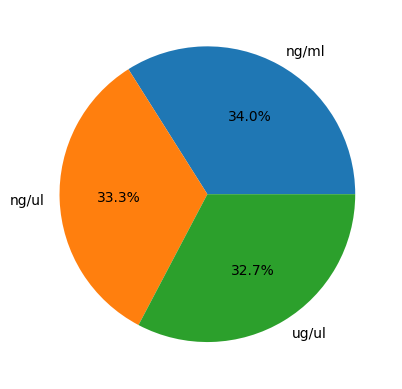


---------- df_onc ----------
               ID  DaysFromAnchorDateToDiagnosisDate  DaysFromAnchorDateToFollowUp       Dead
count   68.000000                          68.000000                     68.000000  68.000000
mean    52.970588                        3812.573529                   4177.941176   0.602941
std     28.929647                        1902.919441                   1956.592270   0.492926
min      1.000000                        -360.000000                   -245.000000   0.000000
25%     29.750000                        2561.500000                   2936.000000   0.000000
50%     54.500000                        4164.500000                   4453.000000   1.000000
75%     77.500000                        5449.750000                   5763.500000   1.000000
max    101.000000                        6340.000000                   6916.000000   1.000000
<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 0 to 69
Data columns (total 5 columns):
 #   Column                

In [3]:
## Filter data by albumin
df_labs['LabChemTestName'] = df_labs['LabChemTestName'].str.lower()
df_labs = df_labs[df_labs['LabChemTestName'].str.contains('^albumin$', na = False)]

## Explore new df_labs
print("\n" + "-"*10 + " df_labs " + "-"*10)
print(df_labs.describe())
print(df_labs.info())
print(f"Num duplicated rows : {df_labs.duplicated().sum()}")
print(f"Num unique values in each col \n {df_labs.nunique()}")

## Look at Units 
vcounts_units = df_labs['Units'].value_counts(dropna = False)
plt.pie(vcounts_units, labels = vcounts_units.index, autopct='%1.1f%%')
plt.show()

# Convert units to ng/ml
def convert_to_ng_per_ml(row):
    value = row['Value']
    unit = row['Units'].strip().lower()  # remove extra spaces + lowercase

    if unit == 'ng/ml':
        return value
    elif unit == 'ng/ul':
        return value * 1000            # 1 µL = 1/1000 mL
    elif unit == 'ug/ul':
        return value * 1_000_000       # 1 µg = 1000 ng, 1 µL = 1/1000 mL
    else:
        return np.nan  # or raise a warning

# Apply the function
df_labs['Albumin_ng_per_ml'] = df_labs.apply(convert_to_ng_per_ml, axis=1)

# Handle nans in df_onc
df_onc.dropna(subset = ['DaysFromAnchorDateToDiagnosisDate', 'DaysFromAnchorDateToFollowUp'], inplace = True)
df_onc.drop_duplicates(inplace = True)

print("\n" + "-"*10 + " df_onc " + "-"*10)
print(df_onc.describe())
print(df_onc.info())
print(f"Num duplicated rows : {df_onc.duplicated().sum()}")
print(f"Num unique values in each col \n {df_onc.nunique()}")

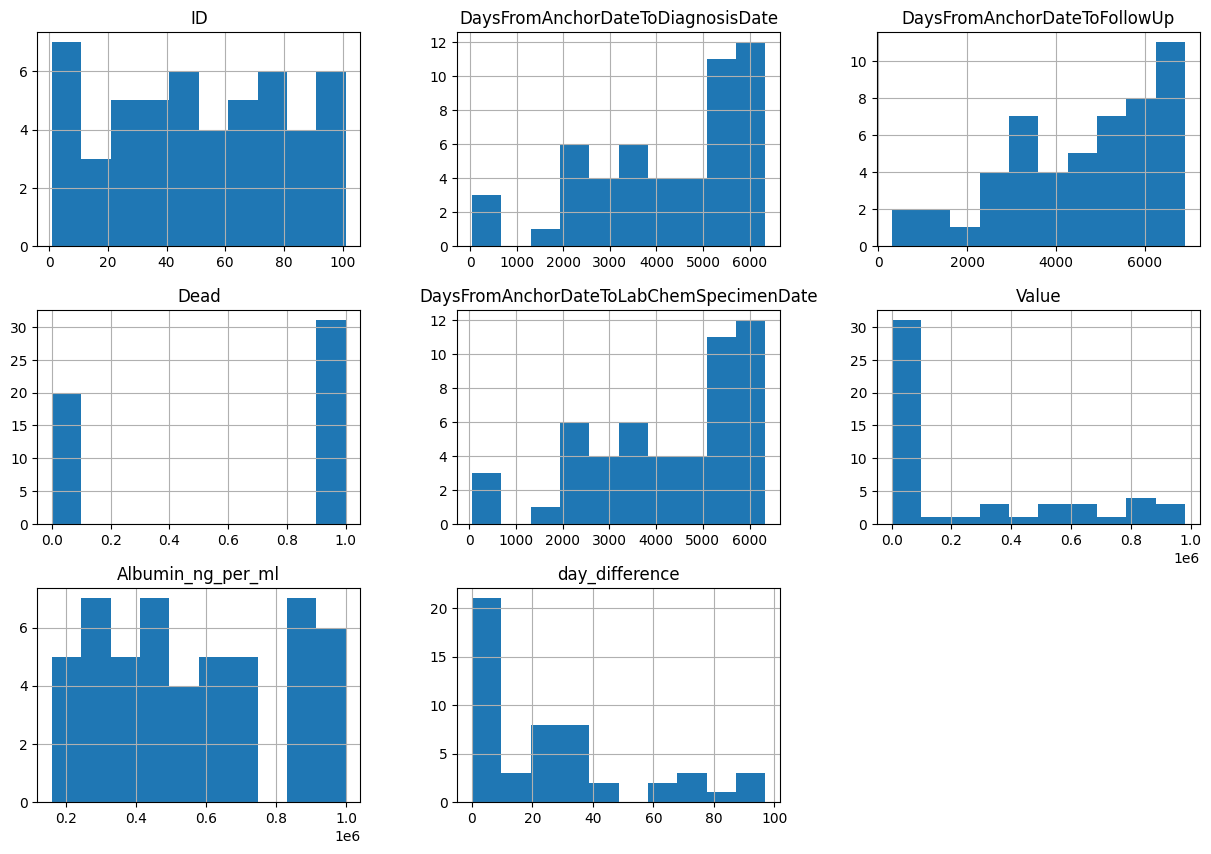

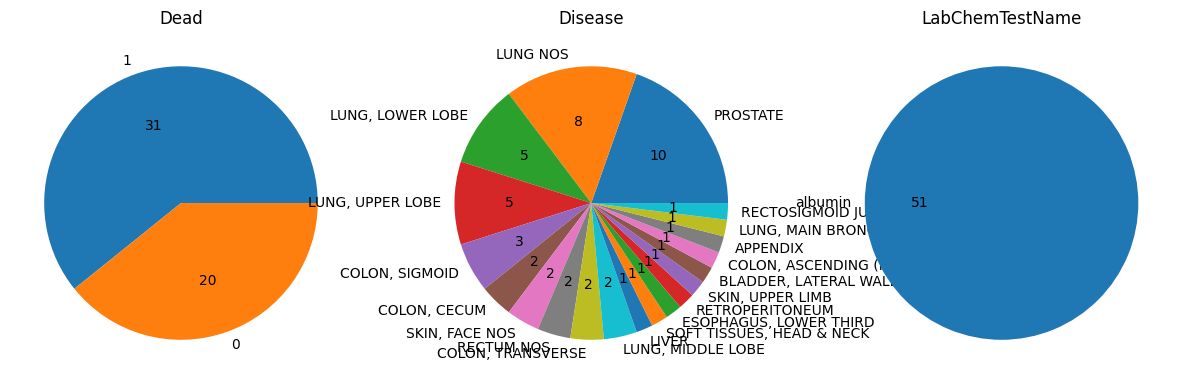

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 0 to 2200
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       51 non-null     int64  
 1   Disease                                  51 non-null     object 
 2   DaysFromAnchorDateToDiagnosisDate        51 non-null     float64
 3   DaysFromAnchorDateToFollowUp             51 non-null     float64
 4   Dead                                     51 non-null     int64  
 5   LabChemTestName                          51 non-null     object 
 6   DaysFromAnchorDateToLabChemSpecimenDate  51 non-null     float64
 7   Value                                    51 non-null     float64
 8   Units                                    51 non-null     object 
 9   Albumin_ng_per_ml                        51 non-null     float64
 10  day_difference                           51 non-null   

In [4]:
# Merge data and explore 
df = pd.merge(df_onc, df_labs, how = "left", on = "ID")
#print(df.describe())
#print(df.info())

# Insight: 5 Ids with missing data --> remove 
df.dropna(subset = ['LabChemTestName'], inplace = True)
#print(df.describe())
#print(df.info())

# Keep only closest date to diagnosis date 
df['day_difference'] = abs(df['DaysFromAnchorDateToLabChemSpecimenDate'] - df['DaysFromAnchorDateToDiagnosisDate'])
df = df.loc[df.groupby('ID')['day_difference'].idxmin()]
df = df[df['day_difference']<=100] # Limit to diagnosis day to lab specimen day <= 100 days

# Data Viz
df.hist(figsize = (15,10))
plt.show()

fig, axs = plt.subplots(1,3, figsize = (15,10)) 
axs = axs.flatten()
cat_vars = ['Dead', 'Disease', 'LabChemTestName']
for i, var in enumerate(cat_vars):
    val_counts = df[var].value_counts(dropna = False)
    axs[i].pie(val_counts, labels = val_counts.index, autopct =lambda p: f'{int(round(p * sum(val_counts) / 100))}')
    axs[i].set_title(var)
plt.show()

print(df.info())

## Cleaned dataset
- 51 unique subjects with albumin level at diagnosis (<100 days from diagnosis date)

## Survival Analysis

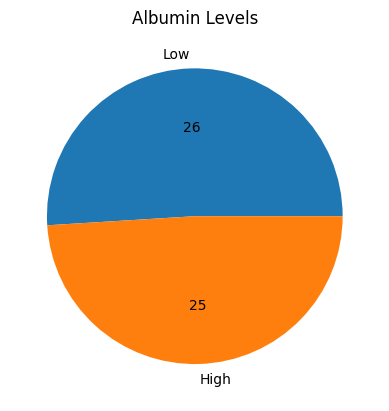

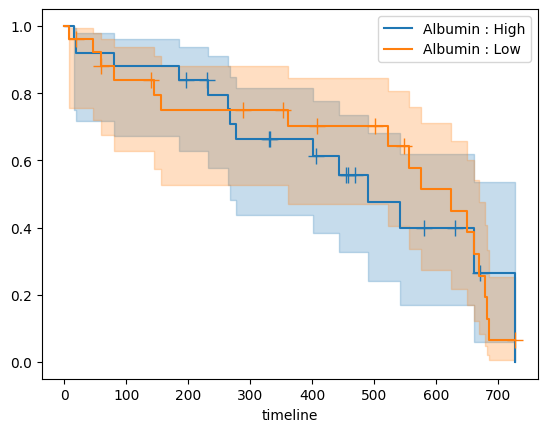

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.11 0.74      0.44

<lifelines.CoxPHFitter: fitted with 51 total observations, 20 right-censored observations>
             duration col = 'Duration'
                event col = 'Dead'
      baseline estimation = breslow
   number of observations = 51
number of events observed = 31
   partial log-likelihood = -91.85
         time fit was run = 2025-07-31 22:28:50 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
Albumin_ng_per_ml  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

                   cmp to    z    p  -log2(p)
covariate                                    
Albumin_ng_per_ml    0.00 0.12 0.90      0.15
---
Concordance = 0.52
Partial AIC = 185.70
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.15

In [5]:
# Create Duration and categorical variable for albumin level
df['Duration'] = df['DaysFromAnchorDateToFollowUp'] - df['DaysFromAnchorDateToDiagnosisDate']
df['albumin_cat'] = ['Low' if  df['Albumin_ng_per_ml'].iloc[i] <= df['Albumin_ng_per_ml'].median() else 'High' for i in range(0, len(df))]

# Ensure ~equal distribution of 'High' and 'Low' albumin levels
value_counts = df['albumin_cat'].value_counts()
plt.pie(value_counts, labels = value_counts.index, autopct=lambda p: f'{int(round(p * sum(value_counts) / 100))}')
plt.title('Albumin Levels')
plt.show()

# Kaplan Meier Plot
kmf = KaplanMeierFitter()
for level in df['albumin_cat'].unique() : 
    df_temp = df[df['albumin_cat'] == level ]
    kmf.fit(df_temp['Duration'], df_temp['Dead'], label = f"Albumin : {level}")
    kmf.plot_survival_function(show_censors = True)
plt.show()

# Log Rank Tests 
low = df[df['albumin_cat'] == 'Low' ]
high = df[df['albumin_cat'] == 'High' ]
logrank_result = logrank_test(low['Duration'], high['Duration'], event_observed_A=low['Dead'], event_observed_B=high['Dead'])
logrank_result.print_summary()


# Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df[['Duration', 'Dead', 'Albumin_ng_per_ml']], duration_col='Duration', event_col='Dead')
cph.print_summary()

## Interpretation
- Kaplan Meier Plot : At 365 days after diagnosis, there is ~ 70% chance that subjects with higher albumin levels survive, and ~75% chance that subjects with a lower albumin level survive. 
- Log Rank Test : There is no significant difference in survival in high albumin level subjects vs low albumin level subjects
- Cox Proportional Hazard Model : Albumin_ng_per_ml has no effect on survival 

## Logistic Regression

In [6]:
# Identify subjects who survived 1 year
df['Survived1year'] = (df['Duration'] >= 365) & (df['Dead'] == 0)
df['Survived1year'] = df['Survived1year'].astype(float)

y = df['Survived1year']
x = df[['albumin_cat']]

formula = '''Survived1year ~ albumin_cat'''

y, X = dmatrices(formula, data=df, return_type='dataframe')
model = LogisticRegression()
model.fit(X, y)
output_df = pd.DataFrame()
output_df['columns'] = X.columns
output_df['coefs'] = model.coef_[0].round(2)
print(output_df.sort_values(by=['coefs'], ascending = False))

              columns  coefs
0           Intercept   0.00
1  albumin_cat[T.Low]  -0.51


## Interpretation
- Being in the "Low albumin" group decreases the log-odds of survival by 0.51 compared to the "High" albumin group.\
- The model correctly predicts the outcome ~78% of the time.

## Assumptions
- Only looking at albumin values named 'albumin'
- Choosing lab specimen date - diagnosis date of within 100 days is ok
- 'Dead' col meaning 1=dead, 0= alive
- str.contains('^albumin$') captures all the albumin
- Splitting albumin by low/high 

## Other considerations
- No demographic variables which could effect albumin levels
- Didn't include cancer diagnosis type which could effect albumin levels
- splitting albumin by low/high is effective (ie - assuming most levels arent right around median)